In [630]:
import numpy as np
import scipy
import pandas as pd
import os
import sklearn as skl
import utils


import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
#import librosa
#import librosa.display

## Import data

In [639]:
import sys
reload(sys)
sys.setdefaultencoding("ISO-8859-1")

tracks_test = pd.read_csv('/Users/kathyli/Downloads/fma_metadata/tracks_edited_v2.csv', header=None)

In [637]:
tracks_test.to_csv('tracks_edited_v4.csv', index = False)

In [403]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = pd.read_csv('/Users/kathyli/Downloads/fma_metadata/tracks.csv', header=None)
genres = pd.read_csv('/Users/kathyli/Downloads/fma_metadata/genres.csv', header=None)
features = pd.read_csv('/Users/kathyli/Downloads/fma_metadata/features.csv', header=None)
echonest = pd.read_csv('/Users/kathyli/Downloads/fma_metadata/echonest.csv', header=None)

#np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106577, 53), (164, 5), (106578, 519), (13133, 250))

## Explore data

In [50]:
#look at diff genres
#look at diff years - plot songs per year
#look at audio file?
#look at song titles - maybe mentions of certain words? most common words in each genre
#correlation between variables
#normalization of data

In [51]:
#all the metadata features for track, album, and artist info
tracks.iloc[0]

#use album release date

Unnamed: 0                  NaN
album                  comments
album.1            date_created
album.2           date_released
album.3                engineer
album.4               favorites
album.5                      id
album.6             information
album.7                 listens
album.8                producer
album.9                    tags
album.10                  title
album.11                 tracks
album.12                   type
artist        active_year_begin
artist.1        active_year_end
artist.2      associated_labels
artist.3                    bio
artist.4               comments
artist.5           date_created
artist.6              favorites
artist.7                     id
artist.8               latitude
artist.9               location
artist.10             longitude
artist.11               members
artist.12                  name
artist.13      related_projects
artist.14                  tags
artist.15               website
artist.16        wikipedia_page
set     

In [80]:
#get year from release date
from datetime import datetime
track_recorded_year = []

for x in range(len(tracks['track.4'])):
    if type(tracks['track.4'][x])==str:
        track_recorded_year.append(tracks['track.4'][x][0:4])

In [110]:
#see which year had most songs released
import collections
counter=collections.Counter(track_recorded_year)
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(3))

#2008 and 2009 have the most songs recorded

Counter({'2008': 1952, '2009': 608, '2005': 429, '2007': 354, '2016': 327, '2006': 321, '2010': 220, '2003': 216, '1997': 163, '2004': 163, '2011': 124, '2013': 119, '2012': 115, '2002': 115, '2001': 109, '2015': 93, '2000': 75, '1999': 65, '1998': 56, '2014': 49, '1982': 37, '2017': 33, '1914': 31, '1995': 30, '1981': 26, '1915': 24, '1919': 24, '1922': 22, '1911': 18, '1996': 18, '1986': 17, '1917': 15, '1913': 13, '1907': 12, '1977': 12, '1990': 11, '1921': 11, '1905': 10, '1916': 10, '1909': 9, '1904': 9, '1984': 9, '1906': 8, '1987': 7, '1910': 7, '1991': 7, '1920': 6, '1912': 6, '1908': 5, '1985': 5, '1988': 4, '1918': 4, '1994': 4, '1899': 3, '1901': 3, '1983': 3, '1993': 2, '1978': 2, '1989': 1, '1896': 1, '1902': 1, '1980': 1, '1940': 1, '1903': 1, '1955': 1, 'date': 1, '1992': 1, '1897': 1})
[1, 6, 18, 22, 3, 5, 9, 8, 12, 1, 10, 1, 9, 3, 17, 7, 9, 5, 37, 3, 1, 26, 1, 12, 4, 1, 93, 49, 33, 327, 124, 220, 119, 115, 11, 1, 4, 1, 7, 13, 6, 24, 31, 15, 10, 7, 24, 2, 1, 30, 4, 163,

In [111]:
#split by genre - look at number of songs in each genre and pick top 5 genres
import collections
counter=collections.Counter(tracks['track.7'])
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(10))

#rock, experimental, electronic, hip-hop, folk, pop, instrumental, international, classical

Counter({nan: 56977, 'Rock': 14182, 'Experimental': 10608, 'Electronic': 9372, 'Hip-Hop': 3552, 'Folk': 2803, 'Pop': 2332, 'Instrumental': 2079, 'International': 1389, 'Classical': 1230, 'Jazz': 571, 'Old-Time / Historic': 554, 'Spoken': 423, 'Country': 194, 'Soul-RnB': 175, 'Blues': 110, 'Easy Listening': 24, 'genre_top': 1})
[56977, 2803, 2079, 1230, 423, 194, 571, 554, 2332, 24, 175, 3552, 14182, 1, 1389, 110, 9372, 10608]
[nan, 'Folk', 'Instrumental', 'Classical', 'Spoken', 'Country', 'Jazz', 'Old-Time / Historic', 'Pop', 'Easy Listening', 'Soul-RnB', 'Hip-Hop', 'Rock', 'genre_top', 'International', 'Blues', 'Electronic', 'Experimental']
[(nan, 56977), ('Rock', 14182), ('Experimental', 10608), ('Electronic', 9372), ('Hip-Hop', 3552), ('Folk', 2803), ('Pop', 2332), ('Instrumental', 2079), ('International', 1389), ('Classical', 1230)]


## Clean data

In [108]:
#need to remove rows for which 'track.4' (track release date) is NaN and for which 'track.7' (genre) is NaN
tracks_with_release_date = tracks[pd.isnull(tracks['track.4'])==False]
tracks_clean = tracks_with_release_date[pd.isnull(tracks_with_release_date['track.7'])==False]

In [120]:
tracks_clean

,Unnamed: 0,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,...,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19,year_recorded
0,NaN,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,interest,language_code,license,listens,lyricist,number,publisher,tags,title,date
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food,NaN
3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave,2008
4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World,2008
5,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway,2008
11,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,1126,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,NaN,5,NaN,[],Street Music,2008
12,135,1,2008-11-26 01:49:19,2009-01-07 00:00:00,NaN,0,58,<p>A couple of unreleased mp3s from the fellas...,3331,NaN,...,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day,2008
13,136,1,2008-11-26 01:49:19,2009-01-07 00:00:00,NaN,0,58,<p>A couple of unreleased mp3s from the fellas...,3331,NaN,...,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky,2008
14,137,1,2008-11-26 01:49:35,2006-12-01 00:00:00,NaN,2,59,<p>Here's the proof in the pudding that the as...,1681,NaN,...,2559,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1278,NaN,1,NaN,['lafms'],Side A,2008
15,138,1,2008-11-26 01:49:35,2006-12-01 00:00:00,NaN,2,59,<p>Here's the proof in the pudding that the as...,1681,NaN,...,1909,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,489,NaN,2,NaN,['lafms'],Side B,2008


In [118]:
#get year from release date
track_recorded_year_clean = []

for x in range(len(tracks_clean['track.4'])):
    if type(tracks['track.4'][x])==str:
        track_recorded_year_clean.append(tracks['track.4'][x][0:4])
    else:
        track_recorded_year_clean.append(np.nan)

#add year as column to dataframe
tracks_clean['year_recorded'] = track_recorded_year_clean

/Users/kathyli/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [116]:
#see which year had most songs released
import collections
counter=collections.Counter(track_recorded_year_clean)
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(3))

#2008 and 2006 have the most songs recorded that also have genre info

Counter({'2008': 1754, nan: 879, '2006': 227, '2007': 208, '2003': 202, '2005': 161, '1997': 145, '2004': 130, '2009': 129, '2001': 93, '2002': 88, '1999': 61, '2000': 42, '1981': 26, '1995': 24, '1996': 14, '1982': 10, '1915': 8, '1998': 8, '1914': 7, '1991': 6, '1986': 5, '1911': 4, '1910': 3, '1909': 2, '1907': 2, '1913': 2, '1978': 2, '1920': 1, '1906': 1, '1896': 1, '1905': 1, '1940': 1, '1955': 1, 'date': 1, '1912': 1, '1916': 1, '1994': 1})
[879, 1, 4, 2, 1, 2, 1, 1, 5, 10, 26, 1, 1, 1, 3, 2, 1, 8, 7, 1, 6, 24, 1, 145, 14, 61, 8, 2, 88, 202, 42, 93, 227, 208, 130, 161, 1754, 129]
[nan, '1920', '1911', '1909', '1906', '1907', '1896', '1905', '1986', '1982', '1981', '1940', '1955', 'date', '1910', '1913', '1912', '1915', '1914', '1916', '1991', '1995', '1994', '1997', '1996', '1999', '1998', '1978', '2002', '2003', '2000', '2001', '2006', '2007', '2004', '2005', '2008', '2009']
[('2008', 1754), (nan, 879), ('2006', 227)]


In [117]:
#split by genre - look at number of songs in each genre and pick top 5 genres
counter=collections.Counter(tracks_clean['track.7'])
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(10))

#rock, experimental, electronic, folk, old-time/historic, international, spoken, classical, jazz, pop

Counter({'Rock': 1843, 'Experimental': 696, 'Electronic': 417, 'Folk': 316, 'Old-Time / Historic': 238, 'International': 156, 'Spoken': 108, 'Classical': 92, 'Jazz': 87, 'Pop': 80, 'Hip-Hop': 55, 'Instrumental': 49, 'Soul-RnB': 42, 'Blues': 42, 'Country': 30, 'genre_top': 1})
[49, 92, 55, 30, 87, 238, 80, 42, 108, 696, 1843, 1, 156, 42, 417, 316]
['Instrumental', 'Classical', 'Hip-Hop', 'Country', 'Jazz', 'Old-Time / Historic', 'Pop', 'Soul-RnB', 'Spoken', 'Experimental', 'Rock', 'genre_top', 'International', 'Blues', 'Electronic', 'Folk']
[('Rock', 1843), ('Experimental', 696), ('Electronic', 417), ('Folk', 316), ('Old-Time / Historic', 238), ('International', 156), ('Spoken', 108), ('Classical', 92), ('Jazz', 87), ('Pop', 80)]


In [126]:
#add track recorded year to dataframe - need to figure out what the dataframe should be (i.e., only years 2008
#with genre info - top 5 genres?)
tracks_2008 = tracks_clean[tracks_clean['year_recorded'] == '2008']

#top genres for 2008
counter=collections.Counter(tracks_2008['track.7'])
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(10))

Counter({'Rock': 796, 'Experimental': 277, 'Electronic': 190, 'Folk': 157, 'International': 76, 'Pop': 54, 'Jazz': 45, 'Old-Time / Historic': 39, 'Spoken': 39, 'Blues': 23, 'Country': 22, 'Soul-RnB': 14, 'Hip-Hop': 11, 'Classical': 6, 'Instrumental': 5})
[5, 6, 11, 22, 45, 39, 54, 14, 39, 277, 796, 76, 23, 190, 157]
['Instrumental', 'Classical', 'Hip-Hop', 'Country', 'Jazz', 'Old-Time / Historic', 'Pop', 'Soul-RnB', 'Spoken', 'Experimental', 'Rock', 'International', 'Blues', 'Electronic', 'Folk']
[('Rock', 796), ('Experimental', 277), ('Electronic', 190), ('Folk', 157), ('International', 76), ('Pop', 54), ('Jazz', 45), ('Old-Time / Historic', 39), ('Spoken', 39), ('Blues', 23)]


In [137]:
#this is 2008 tracks with top 5 genres
#tracks_2008_top_genres = tracks_2008[(tracks_2008['track.7'] == 'Rock') | (tracks_2008['track.7'] == 'Experimental') | (tracks_2008['track.7'] == 'Electronic') | (tracks_2008['track.7'] == 'Folk') | (tracks_2008['track.7'] == 'International')]

## Explore data

In [179]:
#merge track info with echonest info, on track id
tracks_with_echonest_data = tracks_2008[tracks_2008['Unnamed: 0'].isin(echonest['Unnamed: 0'])]
echonest_data = echonest[echonest['Unnamed: 0'].isin(tracks_2008['Unnamed: 0'])]

merged_track_echonest = pd.merge(tracks_with_echonest_data, echonest_data, on = 'Unnamed: 0')

#echonest data isn't available for every track, so we end up having to drop more - so now we have data from 2008 
#with genre info, with echonest data

#now we find top genres
counter=collections.Counter(merged_track_echonest['track.7'])
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(10))

Counter({'Rock': 600, 'Electronic': 151, 'Folk': 127, 'Pop': 32, 'International': 23, 'Blues': 22, 'Jazz': 21, 'Old-Time / Historic': 20, 'Hip-Hop': 8})
[21, 20, 32, 8, 600, 23, 22, 151, 127]
['Jazz', 'Old-Time / Historic', 'Pop', 'Hip-Hop', 'Rock', 'International', 'Blues', 'Electronic', 'Folk']
[('Rock', 600), ('Electronic', 151), ('Folk', 127), ('Pop', 32), ('International', 23), ('Blues', 22), ('Jazz', 21), ('Old-Time / Historic', 20), ('Hip-Hop', 8)]


In [184]:
#split into different genres
rock_genre = merged_track_echonest[merged_track_echonest['track.7'] == 'Rock']
electronic_genre = merged_track_echonest[merged_track_echonest['track.7'] == 'Electronic']
folk_genre = merged_track_echonest[merged_track_echonest['track.7'] == 'Folk']

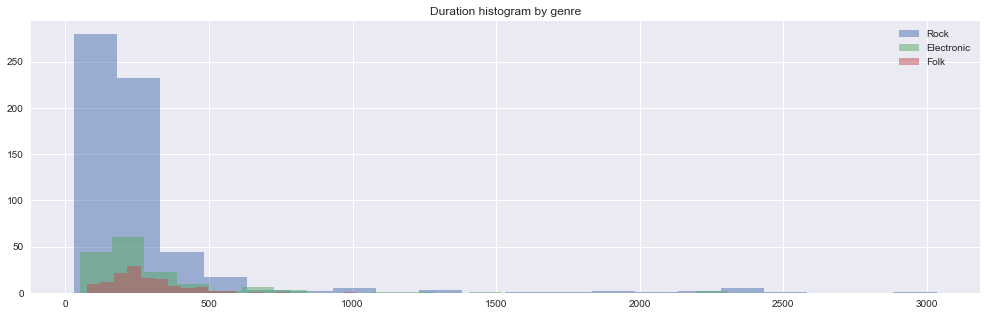

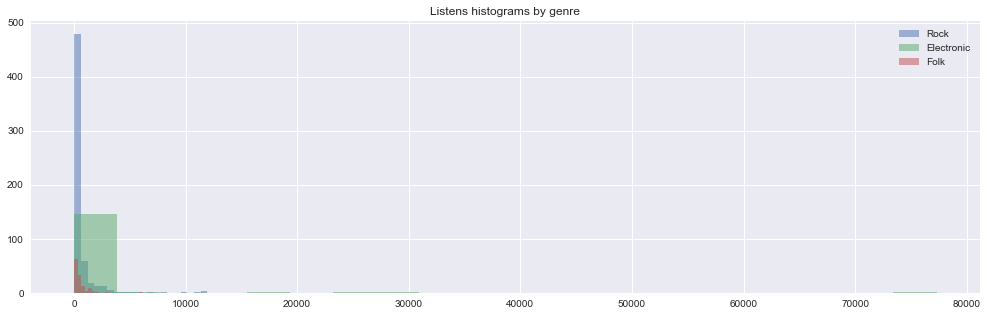

In [199]:
#track.14 is listens, track.5 is duration
#plot histograms of duration
plt.hist(np.array(rock_genre['track.5'], dtype=int), bins = 20, label='Rock', alpha=0.5)

plt.hist(np.array(electronic_genre['track.5'], dtype=int), bins = 20, label='Electronic', alpha=0.5)

plt.hist(np.array(folk_genre['track.5'], dtype=int), bins = 20, label='Folk', alpha=0.5)
plt.title('Duration histogram by genre')

plt.legend()
plt.show()

#plot histograms of listens
plt.hist(np.array(rock_genre['track.14'], dtype=int), bins = 20, label='Rock', alpha=0.5)

plt.hist(np.array(electronic_genre['track.14'], dtype=int), bins = 20, label='Electronic', alpha=0.5)

plt.hist(np.array(folk_genre['track.14'], dtype=int), bins = 20, label='Folk', alpha=0.5)
plt.title('Listens histograms by genre')

plt.legend()

In [238]:
rock_echonest_features = rock_genre[list(echonest)].convert_objects(convert_numeric=True)
echonest_features = echonest_data.convert_objects(convert_numeric=True)

#test2 = rock_genre[['echonest.239', 'echonest.240']]
#test2 = test2.convert_objects(convert_numeric=True)

/Users/kathyli/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
/Users/kathyli/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


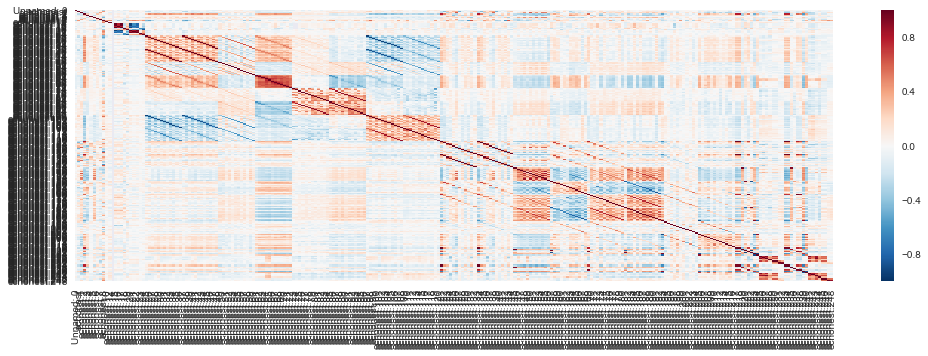

In [239]:
#look at correlation between variables
#plt.matshow(test.corr())

#remove variables where there is above a certain correlation threshold

import seaborn as sns
corr = echonest_features.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
#normalize data

In [ ]:
#audio files - rulan 

## Subset data

In [412]:
#rename columns in data
header = tracks.iloc[1]
header[0] = 'track_ID'
tracks.drop(tracks.index[[0,1,2]], inplace=True)
tracks.rename(columns=header, inplace=True)
tracks.head()

,track_ID,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
3,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
4,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
6,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
7,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [401]:
header = echonest.iloc[2]
header[0]='track_ID'
echonest.drop(echonest.index[[0,1,2,3]],inplace=True)
echonest.rename(columns = header,inplace=True)
echonest.head()

In [416]:
#merge on echonest - only pick songs for which we have echonest info
tracks_with_echonest_data = tracks[tracks['track_ID'].isin(echonest['track_ID'])]
echonest_data = echonest[echonest['track_ID'].isin(tracks_with_echonest_data['track_ID'])]

#rename columns to have intuitive names
'''colnames_dict = dict(zip(tracks.columns.values, tracks.iloc[0]))
tracks_with_echonest_data = tracks_with_echonest_data.rename(columns=colnames_dict)
tracks_with_echonest_data = tracks_with_echonest_data.rename(columns={np.nan:'Unnamed: 0'})'''

merged_echonest_data = pd.merge(tracks_with_echonest_data, echonest_data, on = 'track_ID')
#merged_echonest_data = merged_echonest_data.rename(columns={'Unnamed: 0':'track_id'})

In [417]:
merged_echonest_data

,track_ID,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,...,214,215,216,217,218,219,220,221,222,223
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.9923025370,6.8056936264,0.2330697626,0.1928800046,0.0274549890,0.0640799999,3.6769599915,3.6128799915,13.3166904449,262.9297485352
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.5823311806,8.8893079758,0.2584637702,0.2209050059,0.0813684240,0.0641300008,6.0827698708,6.0186400414,16.6735477448,325.5810852051
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-2.2883579731,11.5271091461,0.2568213642,0.2378199995,0.0601223968,0.0601399988,5.9264898300,5.8663496971,16.0138492584,356.7557373047
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,-3.6629877090,21.5082283020,0.2833518982,0.2670699954,0.1257044971,0.0808200017,8.4140100479,8.3331899643,21.3170642853,483.4038085938
4,134,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,-1.4526963234,2.3563981056,0.2346863896,0.1995500028,0.1493317783,0.0644000024,11.2670698166,11.2026700974,26.4541797638,751.1477050781
5,139,0,2008-11-26 01:49:57,2009-01-16 00:00:00,NaN,1,60,"<p>A full ensamble of strings, drums, electron...",1304,NaN,...,-3.0786671638,12.4115667343,0.2708015740,0.2727000117,0.0252420790,0.0640399978,2.4366900921,2.3726501465,3.8970954418,37.8660430908
6,140,1,2008-11-26 01:49:59,2007-05-22 00:00:00,NaN,1,61,<p>Alec K. Redfearn &amp; The Eyesores: Ellen ...,1300,"Alec K. Refearn, Rob Pemberton",...,-0.9346956015,-0.2609805167,0.3222317100,0.2779799998,0.1367472708,0.0753299966,9.8627195358,9.7873897552,21.9816207886,562.2294311523
7,141,0,2008-11-26 01:49:57,2009-01-16 00:00:00,NaN,1,60,"<p>A full ensamble of strings, drums, electron...",1304,NaN,...,-0.4572981000,-0.1659618020,0.4375027716,0.3073900044,0.3687643409,0.0626299977,11.1888399124,11.1262102127,13.4815311432,232.9935455322
8,142,0,2008-11-26 01:50:03,2005-01-25 00:00:00,NaN,1,62,<p>Recorded at Sound Station Seven and at home...,845,NaN,...,-1.1256052256,1.4784175158,0.2158436328,0.2096599936,0.0157538950,0.0692100003,3.9110200405,3.8418099880,12.5985231400,346.8130493164
9,144,0,2008-11-26 01:50:07,2009-01-06 00:00:00,NaN,0,64,<p><em>A</em>lthough recorded in Providence in...,2014,Tom Buckland,...,-3.4540562630,16.2473049164,0.2450227439,0.2260800004,0.0335089900,0.0706600025,2.9836699963,2.9130098820,10.1232194901,146.1457366943


In [418]:
#renname duplicate columns
duplicate_listens = {'listens': ['album_listens', 'track_listens']}

merged_echonest_data = merged_echonest_data.rename(columns=lambda c: duplicate_listens[c].pop(0) if c in duplicate_listens.keys() else c)

In [419]:
#get album release year from album release date
album_release_year = []

for x in merged_echonest_data['date_released']:
    if type(x)==str:
        album_release_year.append(x[0:4])
    else: 
        album_release_year.append(np.nan)

#add album release year to dataframe
merged_echonest_data['album_release_year'] = album_release_year

In [420]:
#find years with most songs released
import collections
counter=collections.Counter(album_release_year)
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(3))

Counter({nan: 3140, '2010': 1461, '2009': 1426, '2011': 1101, '2008': 1088, '2007': 464, '2012': 380, '2006': 346, '2013': 298, '2014': 245, '2004': 167, '2005': 150, '2015': 145, '2003': 94, '2002': 84, '2001': 69, '1999': 68, '2000': 34, '1997': 25, '1995': 20, '1982': 19, '1998': 17, '1986': 10, '1996': 10, '1981': 6, '1985': 5, '1973': 5, '1992': 3, '1976': 2, '1913': 2, '1909': 1, '1907': 1, '1905': 1, '1902': 1, '1988': 1, '1911': 1, '1912': 1, '1916': 1})
[3140, 2, 1, 1, 1, 1, 10, 5, 19, 6, 1, 145, 245, 1101, 1461, 298, 380, 1, 2, 1, 1, 3, 20, 25, 10, 68, 17, 5, 84, 94, 34, 69, 346, 464, 167, 150, 1088, 1426]
[nan, '1976', '1909', '1907', '1905', '1902', '1986', '1985', '1982', '1981', '1988', '2015', '2014', '2011', '2010', '2013', '2012', '1911', '1913', '1912', '1916', '1992', '1995', '1997', '1996', '1999', '1998', '1973', '2002', '2003', '2000', '2001', '2006', '2007', '2004', '2005', '2008', '2009']
[(nan, 3140), ('2010', 1461), ('2009', 1426)]


In [421]:
#look at top genres for top years
tracks_2010 = merged_echonest_data[merged_echonest_data['album_release_year'] == '2010']

#top genres for 2010
counter=collections.Counter(tracks_2010['genre_top'])
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(10))

#look at top genres for top years
tracks_2009 = merged_echonest_data[merged_echonest_data['album_release_year'] == '2009']

#top genres for 2009
counter=collections.Counter(tracks_2009['genre_top'])
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(10))

Counter({nan: 524, 'Rock': 372, 'Electronic': 271, 'Hip-Hop': 133, 'Folk': 67, 'Pop': 58, 'Jazz': 23, 'International': 12, 'Instrumental': 1})
[524, 23, 58, 1, 67, 372, 12, 271, 133]
[nan, 'Jazz', 'Pop', 'Instrumental', 'Folk', 'Rock', 'International', 'Electronic', 'Hip-Hop']
[(nan, 524), ('Rock', 372), ('Electronic', 271), ('Hip-Hop', 133), ('Folk', 67), ('Pop', 58), ('Jazz', 23), ('International', 12), ('Instrumental', 1)]
Counter({'Rock': 553, nan: 300, 'Electronic': 188, 'Hip-Hop': 137, 'Folk': 122, 'International': 48, 'Jazz': 31, 'Instrumental': 22, 'Pop': 12, 'Blues': 8, 'Classical': 5})
[300, 5, 31, 12, 22, 137, 553, 48, 8, 188, 122]
[nan, 'Classical', 'Jazz', 'Pop', 'Instrumental', 'Hip-Hop', 'Rock', 'International', 'Blues', 'Electronic', 'Folk']
[('Rock', 553), (nan, 300), ('Electronic', 188), ('Hip-Hop', 137), ('Folk', 122), ('International', 48), ('Jazz', 31), ('Instrumental', 22), ('Pop', 12), ('Blues', 8)]


In [422]:
#for each year, print the number of songs that came out in each genre
for i in np.unique(album_release_year):
    #look at top genres for top years
    tracks_year = merged_echonest_data[merged_echonest_data['album_release_year'] == i]

    #top genres for 2009
    counter=collections.Counter(tracks_year['genre_top'])
    #print(counter)
    #print(counter.values())
    #print(counter.keys())
    print(i)
    print(counter.most_common(10))

1902
[(nan, 1)]
1905
[('Old-Time / Historic', 1)]
1907
[('Old-Time / Historic', 1)]
1909
[('Old-Time / Historic', 1)]
1911
[('Old-Time / Historic', 1)]
1912
[('Old-Time / Historic', 1)]
1913
[('Old-Time / Historic', 2)]
1916
[('Old-Time / Historic', 1)]
1973
[('Rock', 5)]
1976
[('Rock', 2)]
1981
[('Rock', 6)]
1982
[('Rock', 16), (nan, 3)]
1985
[('Rock', 5)]
1986
[('Rock', 10)]
1988
[('Rock', 1)]
1992
[('Rock', 3)]
1995
[('Electronic', 14), ('Rock', 4), ('Jazz', 2)]
1996
[('Rock', 10)]
1997
[('International', 11), ('Jazz', 6), ('Rock', 6), (nan, 1), ('Folk', 1)]
1998
[(nan, 15), ('Electronic', 2)]
1999
[('Rock', 55), ('Electronic', 11), (nan, 2)]
2000
[('Rock', 20), ('Electronic', 12), (nan, 1), ('Folk', 1)]
2001
[('Rock', 32), (nan, 25), ('Folk', 6), ('Jazz', 3), ('Electronic', 3)]
2002
[('Rock', 51), ('Blues', 15), ('Electronic', 7), ('Hip-Hop', 7), ('Folk', 4)]
2003
[('Rock', 47), ('Electronic', 25), ('Jazz', 12), (nan, 7), ('Folk', 2), ('Hip-Hop', 1)]
2004
[('Rock', 58), (nan, 56), 

## Lasso regression - rock 2009 and 2010

In [608]:
#lasso regression on select set of features - do feature selection
#choose 2009
rock_2009 = merged_echonest_data[(merged_echonest_data['genre_top'] == 'Rock') & (merged_echonest_data['album_release_year']=='2009')]
electronic_2009 = merged_echonest_data[(merged_echonest_data['genre_top'] == 'Electronic') & (merged_echonest_data['album_release_year']=='2009')]
hip_hop_2009 = merged_echonest_data[(merged_echonest_data['genre_top'] == 'Hip-Hop') & (merged_echonest_data['album_release_year']=='2009')]

In [609]:
#choose 2010
rock_2010 = merged_echonest_data[(merged_echonest_data['genre_top'] == 'Rock') & (merged_echonest_data['album_release_year']=='2010')]
electronic_2010 = merged_echonest_data[(merged_echonest_data['genre_top'] == 'Electronic') & (merged_echonest_data['album_release_year']=='2010')]
hip_hop_2010 = merged_echonest_data[(merged_echonest_data['genre_top'] == 'Hip-Hop') & (merged_echonest_data['album_release_year']=='2010')]

In [610]:
#drop na from 2009 rock
rock_2009.dropna(axis=1,how='any')

,track_ID,comments,date_created,date_released,favorites,id,album_listens,tags,title,tracks,...,215,216,217,218,219,220,221,222,223,album_release_year
15,155,0,2008-11-26 01:51:00,2009-01-06 00:00:00,0,70,197,[],unreleased demo,1,...,15.9821147919,0.3956210613,0.2952800095,0.1199656501,0.0631299987,4.1681199074,4.1049900055,4.0160093307,25.4121437073,2009
18,171,0,2008-11-26 01:51:52,2009-01-06 00:00:00,0,74,346,[],Victim of Your Life,2,...,5.0436997414,0.6895390153,0.4998399913,0.4247204363,0.0736500025,4.2665801048,4.1929302216,2.7170271873,8.7791118622,2009
19,172,0,2008-11-26 01:51:54,2009-01-06 00:00:00,0,75,90,[],Heir to the Power Bear Fortune,1,...,3.0670454502,0.4300648570,0.2905200124,0.1587473601,0.0673900023,2.7398600578,2.6724700928,2.5040278435,8.0228452682,2009
23,176,0,2008-11-26 01:51:52,2009-01-06 00:00:00,0,74,346,[],Victim of Your Life,2,...,11.7448825836,0.4176165164,0.3039000034,0.1536134630,0.0628999993,3.8494300842,3.7865300179,3.7606098652,22.8162517548,2009
25,178,0,2008-11-26 01:52:07,2009-01-06 00:00:00,0,76,149,[],"Tarantula Downpour 7""",1,...,41.2664451599,0.5371587873,0.4176900089,0.2436376512,0.0633099973,3.8844900131,3.8211801052,2.4802823067,8.7396812439,2009
26,179,0,2008-11-26 01:52:09,2009-01-06 00:00:00,0,77,226,[],Dracula Safari,1,...,17.3767414093,0.2409678549,0.2038800120,0.0185696948,0.0634900033,1.0273900032,0.9638999701,2.0526578426,5.7634096146,2009
57,247,0,2008-11-26 01:55:44,2009-01-09 00:00:00,0,100,5613,[],On Opaque Things,4,...,11.4799156189,0.3174915016,0.2436700016,0.1925382614,0.0700199977,9.0610904694,8.9910707474,17.2572135925,339.1313171387,2009
58,249,0,2008-11-26 01:55:44,2009-01-09 00:00:00,0,100,5613,[],On Opaque Things,4,...,5.1569442749,0.2530073524,0.1843499988,0.0918063894,0.0691599995,6.1096601486,6.0405001640,14.9243965149,279.4644470215,2009
59,252,0,2008-11-26 01:55:44,2009-01-09 00:00:00,0,100,5613,[],On Opaque Things,4,...,4.8360619545,0.2976068258,0.2715600133,0.0766769797,0.0691599995,6.4449901581,6.3758301735,18.8578987122,413.8246459961,2009
60,255,0,2008-11-26 01:55:44,2009-01-09 00:00:00,0,100,5613,[],On Opaque Things,4,...,2.3221838474,0.2678501904,0.2441949993,0.0738967881,0.0717900023,6.9134697914,6.8416795731,21.4606590271,520.7977294922,2009


In [362]:
variables_drop = ['track_id', 'comments', 'date_created', 'date_released', 'engineer', 'favorites', 'id', \
                  'information', 'producer', 'tags', 'title', 'tracks', 'type', 'active_year_begin',\
                  'active_year_end', 'associated_labels', 'bio', 'comments', 'date_created', 'favorites', 'id'\
                  'location', 'members', 'name', 'related_projects', 'tags', 'website', 'wikipedia_page', 'composer',\
                  'date_recorded', 'favorites', 'genre_top', 'genres', 'genres_all', 'interest', 'language_code',\
                  'license', 'lyricist', 'number', 'publisher', 'tags', 'title', 'location', 'split', 'subset', 'album_release_year',\
                  'echonest.8',\
                  'echonest.9', 'echonest.10', 'echonest.11', 'echonest.12', 'echonest.13', 'echonest.14', 'echonest.15',\
                  'echonest.16', 'echonest.17', 'echonest.18','echonest.19', 'album_listens']

#echonest.9 has biopsa duszy - why?

In [512]:
#use some metadata features + up to echonest.24
variables_want = ['track_listens', 'bit_rate','duration','acousticness','danceability','energy','instrumentalness','liveness','speechiness','tempo','valence','artist_discovery', 'artist_familiarity','artist_hotttnesss', 'song_currency']
#['bit_rate', 'duration', 'track_listens'] + list(echonest.columns.values[1:26])

In [457]:
echonest.columns.values[1:26]

array(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'speechiness', 'tempo', 'valence', 'album_date',
       'album_name', 'artist_latitude', 'artist_location',
       'artist_longitude', 'artist_name', 'release',
       'artist_discovery_rank', 'artist_familiarity_rank',
       'artist_hotttnesss_rank', 'song_currency_rank',
       'song_hotttnesss_rank', 'artist_discovery', 'artist_familiarity',
       'artist_hotttnesss', 'song_currency', 'song_hotttnesss'], dtype=object)

In [454]:
variables_want

#acousticness, danceability, energy, instrumentalness, liveness, speechiness, tempo, valence, ari
#take out album date, album name, artist_name, release, artist_location

['track_listens',
 'bit_rate',
 'duration',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'speechiness',
 'tempo',
 'valence',
 'artist_discovery',
 'artist_familiarity',
 'artist_hotttnesss',
 'bit_rate']

In [611]:
from sklearn import preprocessing

data_small = rock_2009[variables_want]#.drop(['album_date', 'album_name', 'artist_location','artist_name', 'release'], axis=1)#rock_2009.drop(variables_drop, axis=1).dropna()
y = data_small['track_listens']
X = data_small.drop('track_listens', axis=1)
X['duration'] = (X['duration'].astype(int))/max(X['duration'].astype(int))

#normalize data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

/Users/kathyli/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/kathyli/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


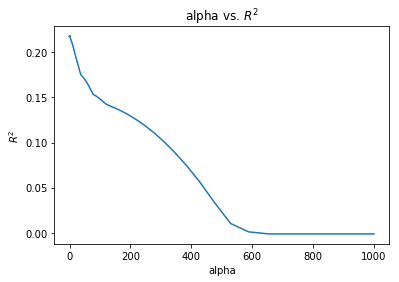

In [612]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#set a range of alphas
alphas = np.logspace(-20,3,500)
scores = []

#split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

#iterate through alpha values and compute R^2, then plot; pick optimal alpha
for alpha in alphas:
    regr = Lasso(alpha=alpha)
    
    #train the model using training data and record the score
    regr.fit(X_train, y_train)
    
    #record score
    scores.append(regr.score(X_test, y_test))

#plot alphas vs. scores
plt.plot(alphas, scores)
plt.xlabel('alpha')
plt.ylabel('$R^2$')
plt.title('alpha vs. $R^2$')
plt.show()

In [613]:
alpha_best = alphas[scores.index(max(scores))]
alpha_best

1.0569345535579873e-15

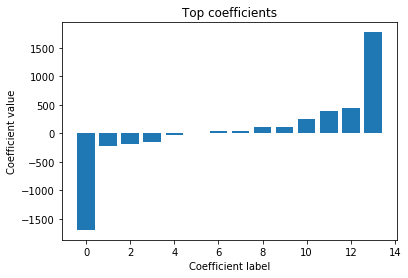

In [614]:
#compute coefficients
regr = Lasso(alpha=alpha_best)
regr.fit(X_train,y_train)
coeffs = np.array(regr.coef_)

#sort and plot coefficients
coeffs = np.sort(coeffs)
plt.bar(range(len(coeffs)), coeffs)
plt.xlabel('Coefficient label')
plt.ylabel('Coefficient value')
plt.title('Top coefficients')
plt.show()

Scores are: [ 0.28030725  0.23180455 -0.91817964  0.2648947   0.13054575]


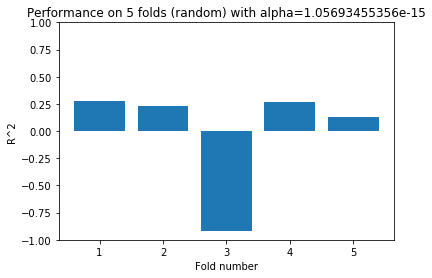

In [615]:
from sklearn.model_selection import ShuffleSplit

#compute R^2 for 5 folds using cross-validation
from sklearn.model_selection import cross_val_score
regr = Lasso(alpha=alpha_best)
regr.fit(X_train,y_train)

#non-randomized
'''scores = cross_val_score(regr, X_scaled, y, cv=5)

print("Scores are: "+ str(scores))

#plot result
plt.ylim([-1,1])
plt.xlabel('Fold number')
plt.ylabel('R^2')
plt.title('Performance on 5 folds (non-randomized) with alpha=' + str(alpha_best))
plt.bar(range(1,6),scores)
plt.show()'''

#random subsets
cv = ShuffleSplit(n_splits=5, test_size=0.2)
scores = cross_val_score(regr, X_scaled, y, cv=cv)

print("Scores are: "+ str(scores))

#plot result
plt.ylim([-1,1])
plt.xlabel('Fold number')
plt.ylabel('R^2')
plt.title('Performance on 5 folds (random) with alpha=' + str(alpha_best))
plt.bar(range(1,6),scores)
plt.show()

In [616]:
from sklearn.cross_validation import KFold

def run_cv_coeffs(X,y,clf_class,alpha):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        
        # Initialize a classifier with alpha
        clf = clf_class(alpha)
        clf.fit(X_train,y_train)
        
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs

coeffs=run_cv_coeffs(X_scaled,np.array(y),Lasso,alpha=alpha_best)

In [617]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(X.columns))]
    return coeffs_avgd, coeffs_std

coeffs_avg,coeffs_std=get_coeffs(coeffs)

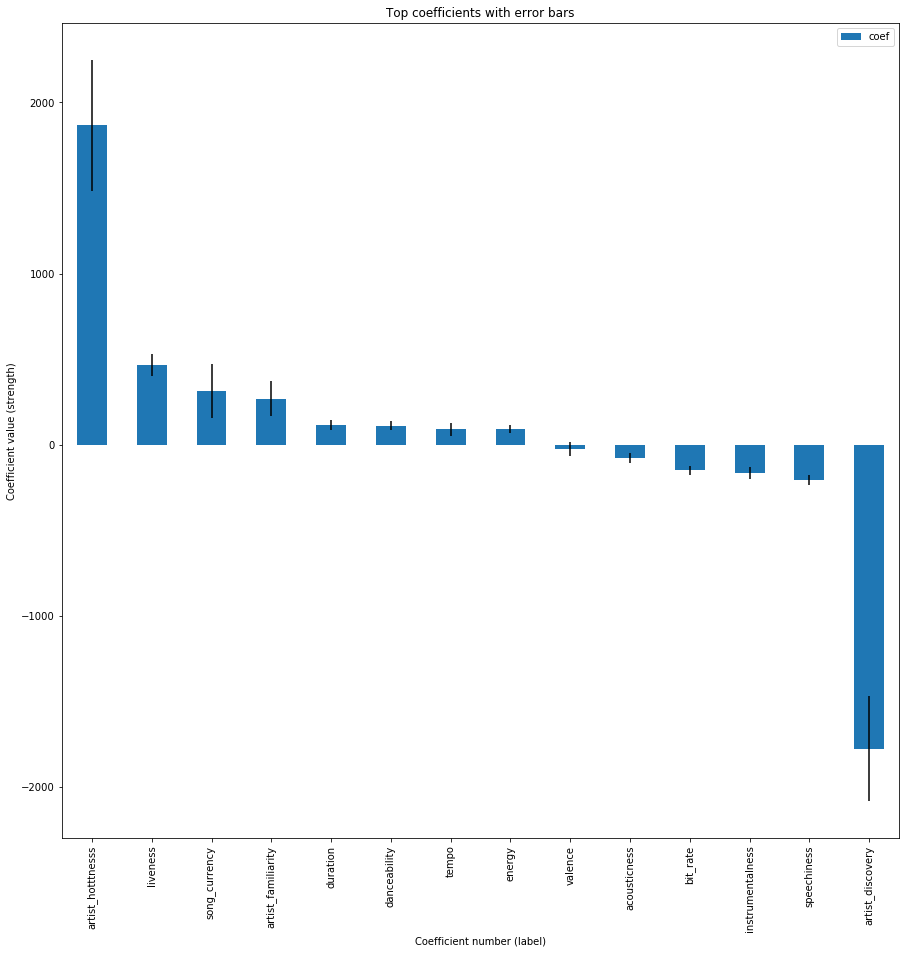

In [618]:
dfCoeffs = pd.DataFrame({'type':X.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]
plt.figure(figsize=(15,15))
dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values
dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))
plt.title('Top coefficients with error bars')
plt.xlabel('Coefficient number (label)')
plt.ylabel('Coefficient value (strength)')
plt.show()

In [620]:
dfCoeffs_sorted

,coef,std,type
12,1867.725232,383.041980,artist_hotttnesss
6,464.627194,65.226694,liveness
13,315.848071,158.019428,song_currency
11,269.344185,102.986548,artist_familiarity
1,116.092609,28.013826,duration
3,110.263951,26.306859,danceability
8,90.468206,37.758404,tempo
4,90.281045,24.141333,energy
9,-24.083282,41.993939,valence
2,-77.543767,27.535393,acousticness


## Version two - start from beginning